In [1]:
#math and linear algebra stuff
import numpy as np

#Math and linear algebra stuff
import scipy.stats as scs

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Information theory, statistics and optimization

## Some notation
Let's talk about a set of N sample vectors $x_i, i=0,1,\dots N-1$ where $x_i \in \mathbb{R}^P$, such that each $x_i$ is an output of a random process, that can be modeled using a probability density function: 
$$
    P_{\theta}(x) = P(x|\theta)
$$
$\theta \in \mathbb{R}^K$ being the pdf parameter vector.

We can also define the empirical data distribution, that sums to one, using:
$$
    P_{D}(x) = \frac{1}{N} \sum_{i=0}^{N-1} \delta(x-x_i)
$$

Where $\delta(x)$ stands for the Dirac delta function. 

## Quantity of information

### Information theory framework
In the framework of information theory, a signal of interest can be modeled as a message produced by a transmitter, enventually modified by the channel, that should be retrieved by the receiver.
The intrinsic complexity of the message, or the quantity of information it contains can be modeled using shannon entropy, defined itself as the expectation of the self information for symbols coming from a given class of message.

### Self information
Self information $I$ of a random event $\omega$ with probability $P(\omega)$ is defined as

$$
    I(\omega) = log\left(\frac{1}{P(\omega)}\right) = -log(P(\omega))
$$

We generally use the logarithm in base 2 so that self information can be defined in bits, and so do the entropy.
Let's list some interesting properties of this metric:
  - as $I$ is a monotically increasing function of $\frac{1}{P(\omega)}$, the realisation of the event that have a low probability gives us a large quantity of information.
  - An event that is not random, ie for wich $P(\omega)=1$ gives no informations.
  - The simultanneous occurence of two independent events $\omega_a$ and $\omega_b$ with respective probability $P(\omega_a)$ and $P(\omega_b)$ bring us a total quantity of infomation equal to the sum of the information of the two events, due to the use of the logarithm.


### Entropy
Shannon entropy $H(x)$, as said earlier is defined as $H(x)=E[I(X)] = E[-log(P(x))]$ which reads in the discrete case:
$$
    H(x) = - \sum_{i=0}^{N-1} P(x_i)log(P(x_i))
$$

It is interesting to notice that $H(x)$ can be interpreted as the entopy rate of a data source or the average number of bits per symbol needed to encode a message whith a known symbol probability density function.

This concept can obviously be extended to blocks or structured blocks of data instead of symbols.

#### A small numerical illustration
Let's say that we have a random bit generator, that can be tuned to generate the value $1$ with a probability $P_1$ varying from $0$ to $1$, the probability that the random bit generator output $0$ is given by $P_0 = 1-P_1$. This is a classic Bernoulli scheme.
The entropy of this binary source is then

\begin{align}
    & -P_1 log_2(P_1) - P_0 log_2(P_0) \\
    =& -P_1 log_2(P_1) -  (1-P_1) log_2(1-P_1)
\end{align}

Let see what does the entropy of this random bit generator, along the value of $P_1$

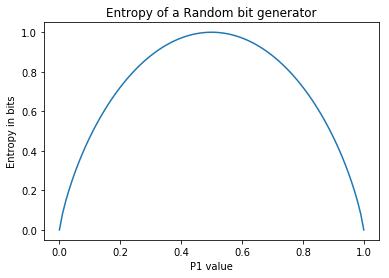

In [2]:
#P1 values:
P1=np.linspace(0,1,101)

#Handle the infinite value of log in 0, so that it returns 0
def SafeLog2( v ):
    r=v.copy()
    r[v!=0]=np.log2(v[v!=0])
    return r

#Entropy of a Bernouilli distribution with probability p
def BernoulliEntropy( p ):
    return -( p*SafeLog2(p)+(1-p)*SafeLog2(1-p) )

#plot entropy functions of P1
plt.plot(P1,BernoulliEntropy(P1))

#Fancy stuff
plt.title('Entropy of a Random bit generator')
plt.xlabel('P1 value')
plt.ylabel('Entropy in bits')

In [3]:
#In some cases later, we will need to compute the entropy of a dataset
def GetEntropyFromQuantizedData( v, num_bins=100 ):
    """
        We assume that v is a vector
    """
    
    #Data is divided in num_bins equally spaced bins, then the histogram is returned
    hist,edges = np.histogram(v,bins=num_bins)
    
    #get the empirical distribution, use floating point division
    p=np.double(hist)/np.sum(hist)

    #scipy entropy simply compute -sum(p * log(p))
    return p, -np.dot(p,SafeLog2(p))

## Relative quantity of information

### Introduction
It is very common in engineering to try to find dependency between data, so that we can exploit some knowledges or intuitions over relationships between them. In some cases, we can measure the validity of this model by measuring the relative quantity of informations given by a random variable when the outcome of some other random process in known, using the following tools:

### Entropy of random Markov process
A common way to give probabilistic interpretation of signals, or messages, is to account for the probability of occurence of a symbol given the 0, 1, 2, ..., p previous symbols in the signal.
This model is known as the order-p Markov source, let's fist see how entropy is computed for a order-1 markov process:
$$
    H(S) = -\sum_i p_i \sum_j p(j|i)log(p(j|i))
$$
Where $j$ is the current symbol, and $i$ is the preceding symbol.

For a second order Markov process, we have:
$$
    H(S) = -\sum_i p_i \sum_j p(j|i) \sum_k p(k|i,j) log(p(k|i,j))
$$

In [4]:
#This code compute the entropy of a markov chain whose matrix is given in parameter
def GetEntropyFromMarkovRandomProcess( markov, prob ):
    """
        We assume that markov is a 2D square matrix that
        stands for a random markov chain.
        For the record, the jth column of the matrix should sum to 1
        and M(i,j) is the probability that an element in the state
        j, will move to the state i, ie p(i|j)
        
        We assume that prob is the probability of each state in the
        same order as in the markov matrix
    """
    
    entropy = 0
    #for each state
    for i in range(markov.shape[0]):
        Pji = markov[i,:]/np.sum(markov[i,:])
        Sent = np.dot(Pji,SafeLog2(Pji))
        entropy += prob[i]*Sent

    return -entropy

#### A small numerical illustration

Let's say that we have a 1 dimensional signal from $\mathbb{Z}^N$, and we want to model the occurence of every new symbol in this signal as a first order random markov process.
This model allows us to study the entropy of the signal in another framework, let's see how entropy values compares in the basic and markov models.

A very interesting basic introduction to markov chain can be found here: http://www.ams.org/samplings/feature-column/fcarc-pagerank
It should help to understand the link between graphs, probability and random linear algebra.

In [5]:
#First: generate a binary sinusoid like signal, of amplitude -1 or 1
nbPeriod = 10
s=np.round(np.cos(np.linspace(0,nbPeriod*2*np.pi,nbPeriod*2+1)))
#drop the last element for pefectly flat histogram (no repetition)
s=s[0:s.size-1]

#Plot signal of interest
plt.figure()
plt.plot(s)
plt.title('sinusoid')

#compute histogram and symbol-wise entropy of this signal
p,entropy=GetEntropyFromQuantizedData(s,2)
print( "Symbol wise model entropy is ",entropy)    

#Now use the first order markov model, by first computing the markov chain matrix
hist,edges = np.histogram(s,bins=2)

#plot the histogram of values in the signal
plt.figure()
plt.bar(edges[:-1], hist, width = 1)
plt.xlim(min(edges), max(edges))
plt.title('histogram, symbol-wise entropy is '+str(entropy))
print "Sum of empirical distribution is ",np.sum(p)

#Define markov matrix
markov=np.zeros((hist.size,hist.size))

#loop over current elements
for i in range(hist.size):
    #index in s where you can find previous element
    if( i < hist.size-1 ):
        curMask = (s>=edges[i]) * (s<edges[i+1])
    else: #last range has both sides included, see numpy doc
        curMask = (s>=edges[i]) * (s<=edges[i+1])
    
    #Now we shift the idx mask toward the right in order
    #to get the mask of the current element
    nextMask = np.roll(curMask, 1)
    n = s[nextMask]
    
    #Check if the current state is present
    if nextMask.any():
        #Get the histogram of the next elements
        for j in range(hist.size):
            #index in s where you can find previous element
            if( j < hist.size-1 ):
                jMask = (n>=edges[j]) * (n<edges[j+1])
            else: #last range has both sides included, see numpy doc
                jMask = (n>=edges[j]) * (n<=edges[j+1])

            #Now fill the ith column, jth line of the markov matrix
            markov[j,i] = np.count_nonzero(jMask)

        #When the ith column of markow matrix is full, we can normalize
        #the weight so that they sum to 1
        sum_weight = np.sum(markov[:,i])
        if sum_weight > 0 :
            markov[:,i] /= sum_weight
        else:
            raise ValueError('Definition of state based on floating range is wrong')
    else:
        #if current state is not present, we assume
        #equiprobable next state, to avoid dangling nodes
        markov[:,i] =  1/hist.size

#Now compute the first order markov model entropy
Mentropy = GetEntropyFromMarkovRandomProcess(markov,p)
print( "First order markov model entropy is ",Mentropy)    

#Print markov matrix for fun
plt.figure()
plt.imshow(markov)
plt.axis('off')
plt.title('Markov matrix, first order markov model entropy is '+str(Mentropy))




SyntaxError: invalid syntax (<ipython-input-5-0f258557a208>, line 24)

The previous numerical case was interesting because, our bit generator is perfectly balanced: there is as much -1 as 1's but it is not random, it is perfectly causal.
The symbol wise entropy definition gives us an entropy of 1 bit, but the first order markov based model give us an entropy of 0, because the same input always generate the same next output, there is no information in this framework.

### Conditional Entropy
The concept of entropy also extends to conditional probability of events, in this case, $H(x|y)$ can be interpreted as the amount of information needed to describe the outcome of a random process x, given the value of the random process y and reads:

\begin{align}
    H(x|y)  &= \sum_{j=1}^{K} p(y_j) H(x|y=y_j) \\
            &= \sum_{j=1}^{K} p(y_j) \sum_{i=1}^{N} -p(x_i|y_j) log(p(x_i|y_j)) \\
            &= -\sum_{j=1}^{K} \sum_{i=1}^{N} p(x_i,y_j) log(p(x_i|y_j)) \\
            &= -\sum_{j\in J,i\in I} p(x_i,y_j) log(p(x_i|y_j)) \\
            &= -\sum_{j\in J,i\in I} p(x_i,y_j) log\left(\frac{p(x_i,y_j)}{p(y_j)}\right) \\
            &=  \sum_{j\in J,i\in I} p(x_i,y_j) log\left(\frac{p(y_j)}{p(x_i,y_j)}\right)
\end{align}


### Cross Entropy
The concept of cross entropy is usefull to characterize the difference between two distributions. 
It gives the numbe of bits needed to encode one symbole from the distribution x, using a code that is optimal for the distribution y.

It reads:
$$
    H(x,y) = \sum_{i \in I} p(x_i) log( p(y_i) )
$$

### Chain rule
If a random process output depends itself on two random variables $x$ and $y$, its entropy can be considered as the joint entropy $H(x,y)$, which in the binary case, is the minimum number of bits needed to describe one output.
If we know in advance the value of $y$, we have gained $H(y)$ bits of information, so we now only need $H(x,y)-H(y)$ to describe the output, that is somehow more deterministic.

This is called the chaine rule and reads:
$$
    H(x|y) = H(x,y)-H(y)
$$

The proof is quite straightforward:

\begin{align}
    H(x|y)  &= \sum_{j\in J,i\in I} p(x_i,y_j) log\left(\frac{p(y_j)}{p(x_i,y_j)}\right) \\
            &= -\sum_{j\in J,i\in I} p(x_i,y_j) log(p(x_i,y_j)) + \sum_{j\in J,i\in I} p(x_i,y_j) log(p(y_j)) \\
            &= H(x,y) + \sum_{j\in J,i\in I} p(x_i,y_j) log(p(y_j)) \text{ which is a marginal distribution}\\
            &= H(x,y) + \sum_{j\in J} p(y_j) log(p(y_j)) \\
            &= H(x,y)-H(y)
\end{align}

### Bayes' rule
The famous Bayes theorem links conditional probability of two random variables, for instance $x$ and $y$:
$$
    p(x|y) = \frac{p(y|x)p(x)}{p(y)}
$$
Following the chain rule, and the fact that $H(x,y)=H(y,x)$ we can easly extends the Bayes rule for conditional entropy:
\begin{align}
    H(x|y)  &= H(x,y)-H(y) \\
            &= H(y,x)-H(y) \\
            &= H(y|x)+H(x)-H(y)
\end{align}

### Mutual information
This quantity gives an indication about the dependence between two random variables, it is more general than correlation coefficient, and not limited to real valued data. [Wikipedia](http://en.wikipedia.org/wiki/Mutual_infomation) gives the following interesting definition:
Mutual information measures the information that X and Y share: it measures how much knowing one of these variables reduces uncertainty about the other. For instance, the mutual information of two independent variables is zero. At the opposite, if X is a deterministic function of Y and vice versa, the mutual information is equal to the entropy of X (or Y) which should be equal.

The mutual information between two random variables $x$ and $y$ reads
$$
    I(x,y) = \sum_{i=1}^{N} \sum_{j=1}^{K} p(x_i,y_j) log\left( \frac{p(x_i,y_j)}{p(x_i)p(y_j)} \right)
$$

We can link this expression to conditional entropy:

\begin{align}
    I(x,y)  &= \sum_{i=1}^{N} \sum_{j=1}^{K} p(x_i,y_j) log\left( \frac{p(x_i,y_j)}{p(x_i)p(y_j)} \right) \\
            &= \sum_{j\in J,i\in I} p(x_i,y_j) log\left( \frac{p(x_i,y_j)}{p(x_i)p(y_j)} \right) \\
            &= \sum_{j\in J,i\in I} p(x_i,y_j) log\left( \frac{p(x_i,y_j)}{p(x_i)} \right) - \sum_{j\in J,i\in I} p(x_i,y_j) log(p(y_j))
\end{align}
Using the fact that
$$
    p(x_i|y_j)p(y_j) = p(y_j|x_i)p(x_i) = p(x_i,y_j)
$$
we can rewrite the left side as
\begin{align}
    & \sum_{j\in J,i\in I} p(x_i,y_j) log\left( \frac{p(x_i,y_j)}{p(x_i)} \right) \\
    &= \sum_{j\in J,i\in I} p(x_i)p(y_j|x_i) log(p(y_j|x_i)) \\
    &= \sum_{i\in I} p(x_i) \sum_{j\in J} p(y_j|x_i) log(p(y_j|x_i)) \\
    &= -\sum_{i\in I} p(x_i) H(y|x=x_i) \\
    &= -H(y|x)
\end{align}
and we can recognize a marginal probability in the right side, which can be rewritten as:
\begin{align}
    & \sum_{j\in J} log(p(y_j)) \sum_{i\in I}p(x_i,y_j) \\
    &= \sum_{j\in J} log(p(y_j))p(y_j) \\
    &= -H(y) \\
\end{align}
The two parts together give:
$$
    I(x,y) = -H(y|x) + H(y)
$$
Doing the same reasoning linearizing $p(x_i)$ out of the log in the denominator of the first expression of $ I(x,y)$ instead of $p(y_j)$ gives:
$$
    I(x,y) = -H(x|y) + H(x)
$$

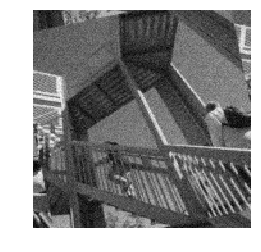

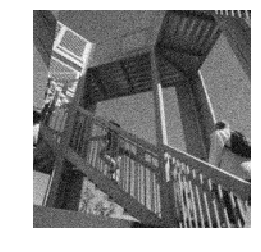

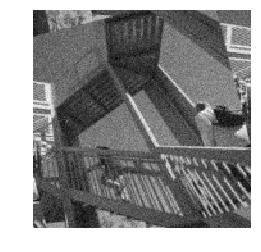

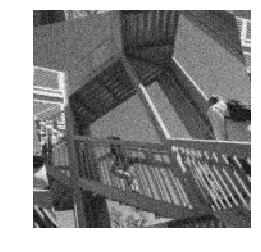

In [31]:
def GetRotMat( theta ):
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

#Example of image super resolution using mutual coherence, first let's take an image
from scipy import misc
import scipy
xsharp = misc.ascent()

#Now, generate n (rotated and shifted and subsampled) + noisy versions
n=4
stack=[]
for i in range(n):
    newIm=np.zeros_like(xsharp)
    #Generate random rotation matrix between -15 and +15 degrees
    rtheta = np.random.uniform(-15,15)*((2*np.pi)/360)
    Mrot = GetRotMat(rtheta)
    #Generate random translation vector, between -5% and +5% of the original size
    maxShift=0.05*np.max(np.array(xsharp.shape))
    shift = np.random.uniform(-maxShift,maxShift,(2))
    
    #Now perform rotation/shift
    center=np.array(newIm.shape)/2
    for x in np.arange(newIm.shape[0]):
        for y in np.arange(newIm.shape[1]):
            pos=np.array([x,y])
            oldIdx=np.dot(Mrot,(pos-center))+center+shift
            oldIdx=(oldIdx%xsharp.shape).astype(int)
            newIm[x,y]=xsharp[oldIdx[0],oldIdx[1]]
    
    #Subsample the image by a factor of 9 (3 times per direction)
    newIm = scipy.misc.imresize(newIm, np.array(xsharp.shape)//3, interp='bilinear')
    
    #Now add a centered gaussian noise of standard deviation equal to 5% of the input image dynamic
    newIm = newIm+np.random.normal(0, scale=newIm.ptp()*0.05,size=newIm.shape)
    newIm = newIm+newIm.min()
    stack.append(newIm)
    
    #Now plot
    plt.figure()
    plt.imshow(newIm, interpolation='nearest', cmap=plt.cm.gray)
    plt.axis("off")


### Kullback Leibler divergence

The Kullback Leibler divergence, also called he relative entropy or discrimination information, can be computed between two distributions, say $x$ and $y$ and writes $ D_{KL}(x\|y) $.
This metric represents the expectation of the difference of the number of bits needed to encode a symbol from the distribution x, weither the encoding is optimal for the distribution x or y.

In the discrete case it reads:

\begin{align}
    D_{KL}(x\|y) &= \sum_{i\in I} p(x_i) log(p(x_i)) -\sum_{i\in I} p(x_i) log(p(y_i)) \\
                 &= -H(x) - H(x,y)
\end{align}
or equivalently
$$
    D_{KL}(x\|y) = \sum_{i\in I} p(x_i) log\left(\frac{p(x_i)}{p(y_i)}\right)
$$


# KL Divergence and maximum likelihood
This chapter was inspired by [this article](http://www.hongliangjie.com/2012/07/12/maximum-likelihood-as-minimize-kl-divergence/)
by Liangjie Hong

## Definitions
Let's consider $P(x_i|\theta)$ a distribution used to generate (or sample) $N$ points $x_i, i=0,\dots,N-1$

We can define a general distribution model as:
$$
    P_\theta(x) = P(x|\theta)
$$
And, to handle data from real world, we will define the following empirical distribution:
$$
    P_D(x) = \sum_{i=0}^{N-1} \frac{1}{N} \delta(x-x_i)
$$

## KL Divergence between model and data
We can now express the Kullback Leibler divergence between the model distribution and the empirical one:

\begin{align}
    D_{KL} \left( P_D(x)||P_\theta(x) \right) &= \int P_D(x) log(P_D(x)) dx -\int P_D(x) log(P_\theta(x)) dx \\
    &= H(P_D(x)) - \int P_D(x) log(P_\theta(x)) dx
\end{align}

As $H(P_D(x))$ is a constant term, relatd to the empirical distribution of real data, we will call it $\epsilon$, and we may get rid of it later.
Instead we will mainly consider, the $\theta$, ie, the model related term:
$$
   D_{KL} \left( P_D(x)||P_\theta(x) \right) = \epsilon -\langle P_D(x) , log(P_\theta(x)) \rangle_{L^2}
$$

Thanks to the definition of the empirical distribution, we can express this continuous expression as a discrete summation:

\begin{align}
    \langle P_D(x) , log(P_\theta(x)) \rangle_{L^2} &= \int \sum_{i=0}^{N-1} \frac{1}{N} \delta(x-x_i) log(P(x|\theta)) dx \\
    &= \sum_{i=0}^{N-1} \frac{1}{N} log(P(x_i|\theta)) \\
    &= \frac{1}{N} \sum_{i=0}^{N-1} log(P(x_i|\theta))
\end{align}

The last line amounts to the log-likelihood of the dataset. We can then conclude that maximizing the log-likelihood of a dataset, relatively to a set of distribution parameters $\theta$ and a given dataset $x$ is equivalent to minimizing the Kullback Leibler divergence between the empirical distribution and the model distribution.

## Practical KL Divergence between two data sets
We are interested in computing the Kullback Leibler divergence between two real datasets $X$ and $Y$, indexed by $i$ where $i$ is the index of a specific event whose occurence probability is $X_i$ according to the model, and $Y_i$ in practice.

As in the definition of the empirical distribution, our datasets must verify:
$$
    \sum_{i=0}^{N-1} X_i = 1
$$

then the expression of the kl divergence is simply:
$$
    D_{KL}(Y\|X) = \sum_{i=0}^{N-1} log \left( \frac{Y_i}{X_i} \right) Y_i dx 
$$

Moreover there is an important condition that must be respected: 
$$
    X_i = 0 \implies Y_i = 0
$$
If so, if the event $k$ has not occurence, we have $X_k=Y_k=0$ and $log \left( \frac{y_k}{x_k} \right) y_k$ has a limit in $0$ which is $0$. Otherwise, Kullback Leibler cannot be computed.

The explanation is pretty straightforward: if an event, or a symbol from $X$ has no occurence in $Y$, it has no reason to be encoded using $Y$ probability distribution, then the average number of bits needed to encode a symbol from $X$ is a nonsense, as some symbols cannot be represented.


## Maximizing the log-likelihood in practice

### Presenting a "hidden variable" kind of problem

We are now going to take a simple example, where we aim to fit a multidimensional noisy dataset, to the sum of independant random poisson processes.

Here is how we formalize the problem:<br>

- Let $\lambda_k = [\lambda_0, \lambda_1,\dots \lambda_{P-1}]$ be the set of parameters of the P hidden Poisson random processes<br>
- The $P$ hidden Poisson random process can be indirectly linked to $N$ observable values using a larger set of random variables $N_{nk}, n<N, k<P$ such that $N_{nk} \sim Poisson\{a_{nk}\lambda_k\}$<br>
- Let $Y_{n} = \sum_{k=0}^{P-1} N_{nk}$ be an observable state vector, defined using a sum of the P hidden poisson process, hence itself being a Poisson process defined as: $Y_{n} \sim Poisson\{ \sum_{k=0}^{P-1}a_{nk}\lambda_k \}$<br>
- Let $y_n$ be a realization of  $Y_{n}$, hence also of dimension N<br>
- Let $A$ be the matrix of size $N\times K$, that contains the $a_{nk}$, known in advance<br>

Althoug this problem with hidden variables may seem weird at first glance, it has some simple instances:

- $\lambda_k$ can be the mean number of cigarets the person $k$ smokes in one hour, among P different persons.<br>
- $Y_{n}$ can be the total number of cigarets smoked in 24 hour in the room $n$, among N rooms.<br>
- $a_{nk}$ is the amount of time in hour the person $k$ has spent in the room $n$ during the measure.<br>

Another well known instance of this problem is the Emission Tomography Reconstruction Problem.

Of course, in every case, our aim will be to retrieve all $\lambda_k$ values.

In [6]:
#We will instanciate the smoker problem:
N=30 #Number of room
P=50 #Number of people

#generate the \lambda_k, for 0<k<P-1, the mean number of cigaret smoked in one hour per each person
#We consider those number uniformly distributed between 0 and 5
LambdaK =  np.random.uniform(1e-2,5,P)

#Now the occupancy matrix, for N rooms and P people:
Ank = np.random.uniform(0,1,(N,P))

#generate the number of cigarets smoked per each person, sequentially in each room

#Here is the independent generation for each person
#yn= np.zeros(N)
#for room in range(N):
#    yn[room] = np.sum(np.random.poisson(lam=Ank[room,:]*LambdaK, size=(1, P)))

#We can exploit the fact that the sum of poisson distribution is a poisson distribution
#This step can be though as applying a poisson noise
yn=np.random.poisson(lam=np.dot(Ank,LambdaK))

#Let's take a look at the pseudo inverse solution
leastSquareSol = np.dot(np.linalg.pinv(Ank),yn)
MSE = np.mean(np.square(leastSquareSol-LambdaK))
print "MSE for least square estimate is "+str(MSE)
        
#Let's take a look at the variance weighted pseudo inverse solution
W = np.diag(1/np.sqrt(yn))
WAnk = np.dot(W,Ank)
Wyn = np.dot(W,yn)
weightedleastSquareSol = np.dot(np.linalg.pinv(WAnk),Wyn)
MSE = np.mean(np.square(weightedleastSquareSol-LambdaK))
print "MSE for weighted least square estimate is "+str(MSE)

SyntaxError: invalid syntax (<ipython-input-6-0d5ce8ce2628>, line 26)

### Solving the problem

Given a realization $y_n$ of $Y_{n}$, we can write the likelihood of this experience as:
$$
L(y_n|Y_n) = \prod_{n=0}^{N-1} \frac{\lambda_{Y_n}^{y_n}e^{-\lambda_{Y_n}}}{y_n!}
$$
with 
- $y_n$ is known
- $\lambda_{Y_n} = \sum_{k=0}^{P-1}a_{nk}\lambda_k$

The log-likelihood comes easily as:
$$
LL(y_n|Y_n) = \sum_{n=0}^{N-1} y_n log(\lambda_{Y_n}) - \lambda_{Y_n} - \epsilon
$$

Where $\epsilon = log(y_n!)$ is a known constant

As $\lambda_{Y_n}$ is actually a linear function of $\lambda_k$, we automatically think about computing the derivative, in order to test some gradient ascent in order to get the maximum log likelihood value:

\begin{align}
    \frac{\partial LL(y_n|Y_n)}{\partial \lambda_k} &= \sum_{n=0}^{N-1} \frac{y_n a_{nk}}{\sum_{i=0}^{P-1} a_{ni}\lambda_i } - a_{nk}
\end{align}

#### Some words about concavity
In order to show that $LL(y_n|Y_n)$ is a concave function, hence compatible with the gradient ascent method, we should be computing the second order partial derivative, and be able to prove that its matix, the Hessian we call $H$ is negative definite. To do so, we can take the quadratic form $xHx$ and show that this form is negative for every $x$ and null only when $x=0$.

Let's begin with the second derivative:
\begin{align}
    \frac{\partial^2 LL(y_n|Y_n)}{\partial \lambda_j \partial \lambda_k} &= -\sum_{n=0}^{N-1} \frac{y_n a_{nk}a_{nj}}{\left( \sum_{i=0}^{P-1} a_{ni}\lambda_i \right)^2}
\end{align}

The Hessian generated by these second order partial derivative is clearly symmetric (Schwartz theorem), and the corresponding quadratic form reads:
\begin{align}
    \sum_{j,k}^{j,k<P-1} x_j \frac{\partial^2 LL(y_n|Y_n)}{\partial \lambda_j \partial \lambda_k} x_k
\end{align}

Reasoning over the rank of the matrix $A$ should allows us to derive negative definiteness of the previous quadratic form, but we won't do it here.

#### Numerical tips
For numerical applications, we will be extending the $Poisson$ distribution to $\mathbb{R}$-valued data using the $Gamma$ function:
\begin{align}
 Poisson2 &: \mathbb{R}^+ \times \mathbb{R}^+ \rightarrow [0,1] \\
 Poisson2(x,\lambda) &= \frac{\lambda^{x} e^{-\lambda}}{\Gamma(x+1)}
\end{align}

0.175467369768
0.175467369768
0.175467369768
0.179901938678


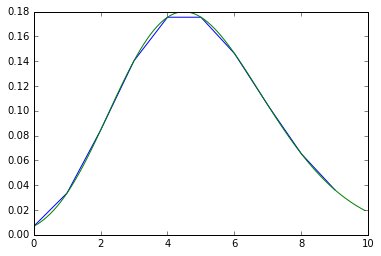

In [8]:
#first, define useful Poisson related function
import scipy.special as scsp

#Poisson distribution
def Poisson(lambdaParam,k):
    return (np.power(lambdaParam,k)*np.exp(-lambdaParam))/np.vectorize(np.math.factorial)(k)

#Extend Poisson distribution to real cases
def Poisson2(lambdaParam,x):
    return (np.power(lambdaParam,x)*np.exp(-lambdaParam))/scsp.gamma(x+1)

lambdaTest = 5
intX = np.arange(0,2*lambdaTest,1) #integer case
realX = np.arange(0,2*lambdaTest,0.1) # real case
PoissonTest = Poisson(lambdaTest,intX) #integer case
Poisson2Test = Poisson2(lambdaTest,realX) # real case

#Check that curve match at integer points, and that
#maximum likelihood is reached for x = 5
plt.plot(intX,PoissonTest)
plt.plot(realX,Poisson2Test)

print Poisson(lambdaTest,5)
print np.max(PoissonTest)
print Poisson2(lambdaTest,5)
print np.max(Poisson2Test)

In [40]:
#now defined likelihood related functions for the smoker problem

#define likelihood of the given candidate solution
def GetLikeliHoodForSmokerProblem( solution, yn, Ank ):
    """
        Implementing the likelihood function for the smoker problem
    """
    LambdaYn = np.dot(Ank,solution)
    return np.prod(Poisson2(LambdaYn,yn))

#define log likelihood of the given candidate solution
def GetLogLikeliHoodForSmokerProblem( solution, yn, Ank ):
    """
        Implementing the Log likelihood function for the smoker problem
    """
    LambdaYn = np.dot(Ank,solution)
    #return np.sum(yn*np.log(LambdaYn)-LambdaYn-np.vectorize(np.math.factorial)(yn))
    return np.sum(yn*np.log(LambdaYn)-LambdaYn-np.log(scsp.gamma(yn+1)))

#define Kullback Liebler Divergence of the given candidate solution
def GetKullbackLieblerDivergenceForSmokerProblem( solution, yn, Ank ):
    """
        Implementing the KL-Divergence function for the smoker problem
    """
    LambdaYn = np.dot(Ank,solution)
    return np.dot(np.log(yn/LambdaYn),yn)

#define the gradient of the Log Likelihood
def LLGrad( solution, yn, Ank ):
    """
        Implementing the Log likelihood function for the smoker problem
    """
    LambdaYn = np.dot(Ank,solution)
    #print str(LambdaYn.shape)
    num = Ank.T*yn
    #print str(num.shape)
    return np.sum((num/LambdaYn)-Ank.T,1)

#Perform gradient Checking over a random point
randomSol = np.random.uniform(1e-2,1e2,P)
epsilon = 1e-4
for dim in range(P):
    mask = np.zeros(P)
    mask[dim] = 1
    numGradMinus = GetLogLikeliHoodForSmokerProblem(randomSol-epsilon*mask,yn, Ank )
    numGradPlus = GetLogLikeliHoodForSmokerProblem(randomSol+epsilon*mask,yn, Ank )
    numGrad = (numGradPlus-numGradMinus)/(2*epsilon)
    #print str(numGrad*mask)
    #print str(LLGrad(randomSol,yn, Ank)*mask)
    assert( np.isclose(numGrad*mask,LLGrad(randomSol,yn, Ank)*mask).all() )


#Check if the Log likelihood gradient is numerically close to zero near the maximum
assert( np.isclose(LLGrad(LambdaK,np.dot(Ank,LambdaK),Ank),np.zeros(P)).all() )

MSE for maximum likelihood estimate is 10.6849734594


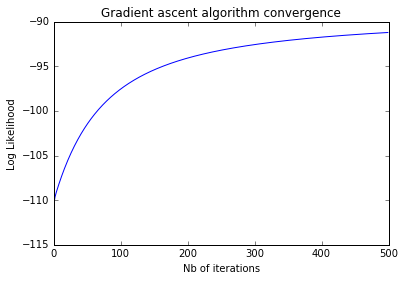

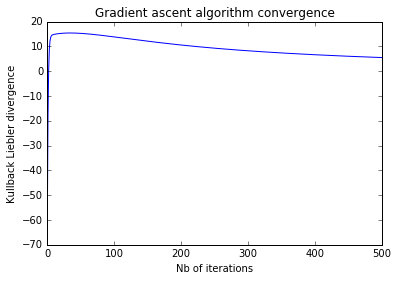

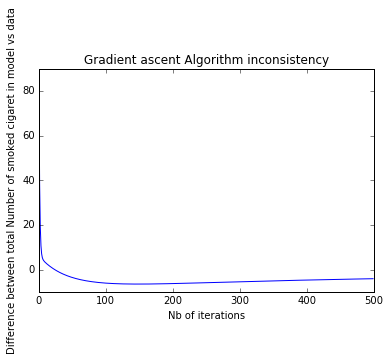

In [60]:
#Lets try to solve this using a simple gradient ascent method
x=np.random.uniform(0,5,P) #initial guess
niter = 500
step = 1e-1
pathLL = []
pathKLD = []
SumData = []

for i in range(niter):
    x = x + step * LLGrad(x,yn,Ank)
    SumData.append(np.dot(Ank,x).sum()-yn.sum())
    pathLL.append( GetLogLikeliHoodForSmokerProblem(x,yn,Ank) )
    pathKLD.append( GetKullbackLieblerDivergenceForSmokerProblem( x, yn, Ank ) )
    
plt.figure()
plt.title('Gradient ascent algorithm convergence')
plt.xlabel('Nb of iterations')
plt.ylabel('Log Likelihood')
plt.plot(pathLL)

plt.figure()
plt.title('Gradient ascent algorithm convergence')
plt.xlabel('Nb of iterations')
plt.ylabel('Kullback Liebler divergence')
plt.plot(pathKLD)

plt.figure()
plt.title('Gradient ascent Algorithm inconsistency')
plt.xlabel('Nb of iterations')
plt.ylabel('Difference between total Number of smoked cigaret in model vs data')
plt.plot(SumData)

#Let's take a look at the maximum likelihood solution
MSE = np.mean(np.square(x-LambdaK))
print "MSE for maximum likelihood estimate is "+str(MSE)


#### A bit of analysis
Although the gradient ascent seen previously seems to provide interesting results, we should notice that equating the derivative to zero in order to find the minimum in a coordinate wise fashion is impossible (no analytical solution).
It seems that we are stuck with ascent method, but one of the drawback of this method, is that it requires a gradient ascent step, which we have chosen manually in this case.<br>
In practice, we could be using a linesearch algorithm in order to choose the right step at every iteration, bu this would need to evaluate the log likelihood multiple times per iteration, which can be costly for large problem sizes.

#### Expectation Maximization Algorithm

##### Introduction

##### Instance of the EM algorithm for our problem

We will now suppose that the extended random variables $N_{nk} = a_{nk}\lambda_k$, that actually only rely on the random variable $\lambda_k$ and he determnistic matix $A$, can be directly observed, and yielded the observation $x_{nk}$, we can express the likelihood of the observation as:
$$
    L(x_{nk}|\lambda_k) = \prod_{n=0}^{N-1}\prod_{k=0}^{P-1} \frac{(a_{nk}\lambda_k)^{x_{nk}}e^{-a_{nk}\lambda_k}}{x_{nk}!}
$$
and log likelihood:
$$
     LL(x_{nk}|\lambda_k) = \sum_{n=0}^{N-1}\sum_{k=0}^{P-1} x_{nk}log(a_{nk}\lambda_k)-a_{nk}\lambda_k-log(x_{nk}!)
$$

This log likelihood is not very useful as such, because we cannot observe directly the $x_{nk}$.
What we can do however, is compute the conditional expectation of $N_{nk}$ given the current estimate of the solution $\lambda_k$ and the observed values $y_n$ and later and replace the unobserved $x_{nk}$ by their expectation: <br>

$$
    \mathbb{E}(N_{nk}|(y_n,\lambda_k))
$$

This actually amounts to derive the expectation of a Poisson variable : $N_{nk}$  of known rate $a_{nk}\lambda_k$, knowing the parameters of the PDF of $P-1$ other Poisson variables $N_{n0},\dots,N_{nk-1},N_{nk+1},\dots,N_{nP-1}$ where the outcome of the sum of all these variable is known : $y_n$.

#### Conditional probability, sum of Poisson distibutions and binomial law

In order to derive the previous conditional expectation, we will need a more general result, that is less known that the additive property of Poisson variables:<br>

Assuming and $X$ and $Y$ are independant Poisson variables, the conditional distribution of $X = k$ given that $X + Y = n$ is binomial with parameters $k$, $n$ and $\frac{\lambda_X}{\lambda_X+\lambda_Y}$ :
$$
P( X = k | X+Y = n ) = Bin(k,n,\frac{\lambda_X}{\lambda_X+\lambda_Y})
$$

With, 
- $X \sim Poisson\{\lambda_X\}$<br>
- $Y \sim Poisson\{\lambda_Y\}$<br>
- $Bin(k,n,p) = \binom{n}{k}p^k(1-p)^{n-k}$

First, consider the random variable $X + Y = N$, we can write
$$
    P(X = x \mid N = n) = \frac{P((X = x) \cap (N = n))}{P(N = n)}= \frac{P((X = x) \cap (Y = n-x))}{P(N = n)}.
$$ 


We can derive the numerator easily using the Poisson distribution function expression and the fact that $X$ and $Y$ are independant so that $P((X = x) \cap (Y = n-x)) = P(X = x)\times P(Y = n-x)$<br>

Let's take a look at the denominator:
$$
\begin{align*}
    P(N = n) &= \sum_{x=0}^n P((X = x) \cap (Y = n-x)) \\
    &= \sum_{x=0}^n e^{-\lambda_X} \frac{\lambda_X^x}{x!} e^{-\lambda_Y} \frac{\lambda_Y^{n-x}}{(n-x)!} \\
    &= e^{-(\lambda_X+\lambda_Y)} \sum_{x=0}^n \frac{n!}{n!} \frac{\lambda_X^x \lambda_Y^{n-x}}{x! (n-x)!} \\ 
    &= \frac{e^{-(\lambda_X+\lambda_Y)}}{n!} \sum_{x=0}^n \binom{n}{x} \lambda_X^x \lambda_Y^{n-x} \\ 
    &= \frac{e^{-(\lambda_X + \lambda_Y)}}{n!} (\lambda_X + \lambda_Y)^n
\end{align*}
$$

which proves that the sum of independent Poisson variables is Poisson with rate equal to the sum of the individual rates. Now let's get back to the conditional expression

$$
\begin{align*}
    P(X = x \mid N = n) &= e^{-\lambda_X} \frac{\lambda_X^x}{x!} e^{-\lambda_Y} \frac{\lambda_Y^{n-x}}{(n-x)!} e^{\lambda_X + \lambda_Y} \frac{n!}{(\lambda_X + \lambda_Y)^n}\\
    &= \frac{\lambda_X^x}{x!} \frac{\lambda_Y^{n-x}}{(n-x)!} \frac{n!}{(\lambda_X + \lambda_Y)^n}\\
    &= \frac{n!}{x!(n-x)!} \frac{\lambda_X^x \lambda_Y^{n-x}}{(\lambda_X + \lambda_Y)^x(\lambda_X + \lambda_Y)^{n-x}}\\
    &= \binom{n}{x} \left(\frac{\lambda_X}{\lambda_X + \lambda_Y}\right)^x \left(\frac{\lambda_Y}{\lambda_X + \lambda_Y}\right)^{n-x}\\
    &=  Bin(k,n,\frac{\lambda_X}{\lambda_X+\lambda_Y})
\end{align*}
$$

Now that we have the proof that the conditional probability is a random variable with a binomial distribution of the form $Bin(k,n,p)$, we can easily derive its expectation $np$ which in ou case gives:

$$
\mathbb{E}[X|X+Y] = \frac{(X+Y)\lambda_X}{\lambda_X+\lambda_Y}
$$

As, we proved how Poisson variables sums, we can easily extend this property to $P$ Poisson distributions:

$$
\mathbb{E}\left[X_k|\sum_{i=0}^{P-1}X_i\right] = \frac{\lambda_{X_k}\sum_{i=0}^{P-1}X_i}{\sum_{i=0}^{P-1}\lambda_{X_i}}
$$

##### Deriving the E-step of the algorithm

The theory behind the EM algorithm tell us that we should first evaluate the expectation of the current log likelihood of the complete dataspace given the current solution, and known data.
This amounts for us, as stated earlier, as replacing the unoberved values of the complete dataspace, by their expectation:

$$
      \mathbb{E}[LL(N_{nk}|(y_n,\lambda_k^c))] = \sum_{n=0}^{N-1}\sum_{k=0}^{P-1} \mathbb{E}[N_{nk}|(y_n,\lambda_k^c)]log(a_{nk}\lambda_k)-a_{nk}\lambda_k-log(\mathbb{E}[N_{nk}|(y_n,\lambda_k^c)]!)
$$

We now know how to derive $E_{nk}$ the conditional expectation of the hidden variables $N_{nk}$, given the actual sum of their realization $y_n$, and the current estimate of their pdf parameter $\lambda_k^c$:
$$
\begin{align*}
    \mathbb{E}[N_{nk}|(y_n,\lambda_k^c)] &= \mathbb{E}\left[N_{nk}|\sum_{i=0}^{P-1} N_{ni}\right]\\
    E_{nk} &= \frac{a_{nk}\lambda_k^c y_n}{\sum_{i=0}^{P-1} a_{ni}\lambda_i^c}
\end{align*}
$$

We now have the analytic expression of the expectation of he log likelihood of the current data. Let's now jump to the maximization part.

##### Deriving the M-step of the algorithm
The second step of the algorithm is the maximization, its intent is simply to find how to update the main unknown so that the expectation function found at the E-step is maximized.

In our case, this simply amount to solve:
$$
\begin{align*}
    &\underset{\lambda_k \in \mathbb{R}^{+}}{max} \mathbb{E}[LL(N_{nk}|(y_n,\lambda_k^c))] \\
    \iff &\underset{\lambda_k \in \mathbb{R}^{+}}{max} \sum_{n=0}^{N-1}\sum_{k=0}^{P-1} E_{nk}log(a_{nk}\lambda_k)-a_{nk}\lambda_k-\epsilon
\end{align*}
$$

with $\epsilon$ a constant equal to $log(E_{nk}!)$

Fortunately, taking the partial derivative of this expression yield a simple result:

$$
    \frac{\partial \mathbb{E}[LL(N_{nk}|(y_n,\lambda_k^c))]}{\partial \lambda_j} = \sum_{n=0}^{N-1} \frac{E_{nj}}{\lambda_j} - \sum_{n=0}^{N-1} a_{nj}
$$

Equated to zero, this expression can be solved easily for updating each unknown $\lambda_k^c$:
\begin{align*}
    0 &= \sum_{n=0}^{N-1} \frac{E_{nj}}{\lambda_j^{c+1}} - \sum_{n=0}^{N-1} a_{nj} \\
    (\lambda_j^{c+1})^{-1} \sum_{n=0}^{N-1} E_{nj} &= \sum_{n=0}^{N-1} a_{nj}\\
    \lambda_j^{c+1} &= \frac{\sum_{n=0}^{N-1} E_{nj}}{\sum_{n=0}^{N-1} a_{nj}} \\
    \lambda_j^{c+1} &= \frac{\lambda_j^c}{\sum_{n=0}^{N-1} a_{nj}} \sum_{n=0}^{N-1} \frac{a_{nj}y_n}{\sum_{i=0}^{P-1} a_{ni}\lambda_i^c} \\
\end{align*}

MSE for maximum likelihood estimate is 9.22603475317


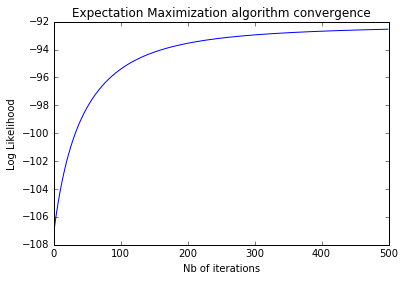

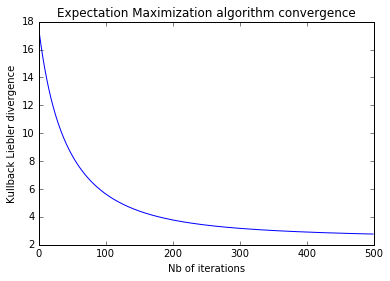

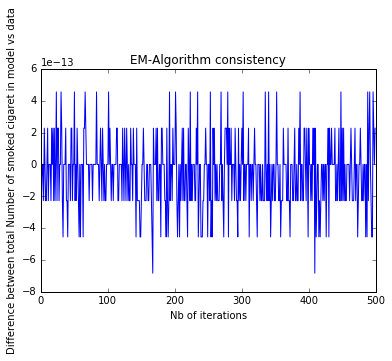

In [61]:
#Let's now implement this EM-Algorithm, and see how its colution compares to other algorithms
x=np.random.uniform(1e-2,5,P) #initial guess
niter = 500
pathLL = []
pathKLD = []
SumData = []
Asum = Ank.sum(0)

for i in range(niter):
    x = np.dot(Ank.T*yn,1/np.dot(Ank,x))*(x/Asum)
    SumData.append(np.dot(Ank,x).sum()-yn.sum())
    pathLL.append( GetLogLikeliHoodForSmokerProblem(x,yn,Ank) )
    pathKLD.append( GetKullbackLieblerDivergenceForSmokerProblem( x, yn, Ank ) )
    
plt.figure()
plt.title('Expectation Maximization algorithm convergence')
plt.xlabel('Nb of iterations')
plt.ylabel('Log Likelihood')
plt.plot(pathLL)

plt.figure()
plt.title('Expectation Maximization algorithm convergence')
plt.xlabel('Nb of iterations')
plt.ylabel('Kullback Liebler divergence')
plt.plot(pathKLD)

plt.figure()
plt.title('EM-Algorithm consistency')
plt.xlabel('Nb of iterations')
plt.ylabel('Difference between total Number of smoked cigaret in model vs data')
plt.plot(SumData)


#Let's take a look at the maximum likelihood solution
MSE = np.mean(np.square(x-LambdaK))
print "MSE for maximum likelihood estimate is "+str(MSE)

#### Some remark about this Expectation Maximization instance

One of the nice property of the EM framework, in addition to the fact that it doesn't require any linesearch, is that it intrinsically handle the equality constraint with the sum of observed data:

\begin{align*}
    \sum_{i=0}^{N-1}\sum_{j=0}^{P-1} a_{ij} \lambda_j^{c+1} &= \sum_{i=0}^{N-1}\sum_{j=0}^{P-1} a_{ij} \frac{\lambda_j^c}{\sum_{n=0}^{N-1} a_{nj}} \underbrace{\sum_{n=0}^{N-1} \frac{a_{nj}y_n}{\sum_{l=0}^{P-1} a_{nl}\lambda_l^c}}_{\text{no term in }i} \\
    &= \sum_{j=0}^{P-1} \underbrace{\sum_{n=0}^{N-1} \frac{a_{nj}y_n}{\sum_{l=0}^{P-1} a_{nl}\lambda_l^c}}_{\text{no term in }i} \sum_{i=0}^{N-1} \frac{a_{ij} \lambda_j^c}{\sum_{n=0}^{N-1} a_{nj}} \\
    &= \sum_{j=0}^{P-1} \underbrace{\sum_{n=0}^{N-1} \frac{a_{nj}y_n}{\sum_{l=0}^{P-1} a_{nl}\lambda_l^c}}_{\text{no term in }i} \lambda_j^c \frac{\sum_{i=0}^{N-1}a_{ij}}{\sum_{n=0}^{N-1} a_{nj}} \\
    &= \sum_{j=0}^{P-1} \sum_{n=0}^{N-1} \frac{a_{nj}y_n\lambda_j^c}{\sum_{l=0}^{P-1} a_{nl}\lambda_l^c}  \\
    &= \sum_{n=0}^{N-1} y_n \sum_{j=0}^{P-1} \frac{ a_{nj}\lambda_j^c}{\underbrace{\sum_{l=0}^{P-1} a_{nl}\lambda_l^c}_{\text{numerator has not term in }j}}  \\
    &= \sum_{n=0}^{N-1} y_n \frac{ \sum_{j=0}^{P-1} a_{nj} \lambda_j^c}{\sum_{l=0}^{P-1} a_{nl}\lambda_l^c}  \\
    &= \sum_{n=0}^{N-1} y_n
\end{align*}

The second nice property of this algorithm, is that, if initialized in the non negative orthant, multiplicative update makes it also intrinsically able to handle the inequality constraint linked to the appartenance of the solution to the non negative orthant:
$$
    \lambda_k^c \in \mathbb{R}^{P-1^{+}}
$$